In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import pinocchio_binning_scheme as binning_scheme

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap
from torch.distributions import Distribution, Uniform, Normal
import pyccl as ccl
from matplotlib.cm import get_cmap

from IPython.display import display, Math


/pbs/home/c/cmurray/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

/tmp/ipykernel_3565/4130027877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


In [3]:
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [4]:
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )
# pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )

In [5]:
richness_cents = np.array( [ ( np.array( pinocchio_mock['richness_bins'] ).T[0] + np.array( pinocchio_mock['richness_bins'] ).T[1] )/2. ])[0]
redshift_cents = np.array( [ ( np.array( pinocchio_mock['redshift_bins'] ).T[0] + np.array( pinocchio_mock['redshift_bins'] ).T[1] )/2. ])[0]

In [6]:
pinocchio_mock['redshift_bins']

[[0.2, 0.36],
 [0.36, 0.52],
 [0.52, 0.6799999999999999],
 [0.6799999999999999, 0.8400000000000001],
 [0.8400000000000001, 1.0]]

In [7]:
richness_bins = list(np.array(pinocchio_mock['richness_bins']).T[0])
richness_bins.append( np.array( pinocchio_mock['richness_bins'] ).T[1][-1]  )

redshift_bins = list(np.array( pinocchio_mock['redshift_bins']).T[0])
redshift_bins.append( np.array( pinocchio_mock['redshift_bins'] ).T[1][-1]  )

In [8]:
redshift_bins

[0.2, 0.36, 0.52, 0.6799999999999999, 0.8400000000000001, 1.0]

In [9]:
richness_bins

[19.999999999999996,
 31.697863849222262,
 50.237728630191604,
 79.62143411069944,
 126.19146889603861,
 199.99999999999991]

In [10]:
def dOmega_func( z ):
    return 0.25 * 4 *np.pi

In [13]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )


stacked_simulator_pl.selection_richness = 0
#stacked_simulator_pl.dOmega = dOmega_z

stacked_simulator_pl.sigma_mwl = 0.25
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.2 , 15.5 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.f_sky = 0.25
stacked_simulator_pl.hmf = ccl.halos.hmfunc.MassFuncDespali16( mass_def= stacked_simulator_pl.massdef )
stacked_simulator_pl.use_hybrid = False
stacked_simulator_pl.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_pl.Z_edges_hybrid[i], stacked_simulator_pl.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_hybrid)-1)]
stacked_simulator_pl.poisson_only = False


stacked_simulator_pl.richness_bins = richness_bins
stacked_simulator_pl.redshift_bins = redshift_bins

In [14]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

def compute_Sij_matrix(cosmo, Z_bin_hybrid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    CLCovar = cl_covar.Covariance_matrix()
    Sij_partialsky_exact_standard = CLCovar.compute_theoretical_Sij(Z_bin_hybrid, cosmo, 
                                                                f_sky,
                                                                S_ij_type='full_sky_rescaled_approx', 
                                                                path=None)
    return Sij_partialsky_exact_standard

def compute_sigmaij_matrix(cosmo, z_grid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    z_grid_center = np.array([(z_grid[i] + z_grid[i+1])/2 for i in range(len(z_grid)-1)])
    CLCovar = cl_covar.Covariance_matrix()
    sigmaij_partialsky_exact_standard = CLCovar.compute_theoretical_sigmaij(z_grid_center, cosmo, f_sky)
    return sigmaij_partialsky_exact_standard

In [133]:


# have_PySSC = False
# if have_PySSC:
#     z_grid = np.linspace(0.2, 1, 1000)
#     stacked_simulator_pl.sigmaij_SSC = compute_sigmaij_matrix(cosmo, z_grid)/stacked_simulator_pl.f_sky
#     save_pickle(stacked_simulator_pl.sigmaij_SSC*stacked_simulator_pl.f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl', )
    
#     stacked_simulator_pl.Sij_SSC = compute_Sij_matrix(cosmo, Z_bin_hybrid)/stacked_simulator_pl.f_sky
#     save_pickle(stacked_simulator_pl.Sij_SSC*stacked_simulator_pl.f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl', )
# else: 
#     S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl' )
#     stacked_simulator_pl.Sij_SSC = S_ij_full_sky/stacked_simulator_pl.f_sky
    
#     sigma_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl' )
#     stacked_simulator_pl.sigmaij_SSC = sigma_ij_full_sky/stacked_simulator_pl.f_sky



In [132]:
stacked_simulator_pl.Sij_SSC = S_ij_full_sky/stacked_simulator_pl.f_sky
stacked_simulator_pl.sigmaij_SSC = sigma_ij_full_sky/stacked_simulator_pl.f_sky


In [134]:
stacked_simulator_hm = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )


stacked_simulator_hm.selection_richness = 0
#stacked_simulator_pl.dOmega = dOmega_z

stacked_simulator_hm.sigma_mwl = 0.25
stacked_simulator_hm.include_mwl_measurement_errors = False
stacked_simulator_hm.correlation_mass_evolution = False
stacked_simulator_hm.set_richness_mass_relation( 'constantins model' )
stacked_simulator_hm.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.2 , 15.5 , 0.001))
stacked_simulator_hm.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_hm.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
stacked_simulator_hm.f_sky = 0.25
stacked_simulator_hm.hmf = ccl.halos.hmfunc.MassFuncDespali16( mass_def= stacked_simulator_pl.massdef )
stacked_simulator_hm.use_hybrid = False
stacked_simulator_hm.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_hm.Z_edges_hybrid[i], stacked_simulator_hm.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_hm.Z_edges_hybrid)-1)]
stacked_simulator_hm.poisson_only = False


stacked_simulator_hm.richness_bins = richness_bins
stacked_simulator_hm.redshift_bins = redshift_bins

In [135]:
stacked_simulator_hm.Sij_SSC = S_ij_full_sky/stacked_simulator_pl.f_sky
stacked_simulator_hm.sigmaij_SSC = sigma_ij_full_sky/stacked_simulator_pl.f_sky

In [149]:
def constantin_power_law( mu , z , alpha_l, c_l, beta_l ):
    log10m0 = 14.3
    log10m = np.log10( np.exp( mu ) * 1e14 )
    print( c_l , beta_l , alpha_l )
    mean_ln_l = c_l + alpha_l * ( log10m - log10m0 )
    # poisson realisation of this values
    #ln_l = np.log( np.random.poisson( lam = np.exp( mean_ln_l )  ) )
    return np.exp( mean_ln_l ) 

def halo_model( mu , z , alpha_l, B , log10Mmin ):
    Mmin = 10**log10Mmin
    M1 = 10**( B ) * Mmin
    M = ( np.exp( mu ) * 1e14 )
    mean_l = ( ( M - Mmin ) / ( M1 -  Mmin ) )**alpha_l 
    mean_l[ np.logical_or( mean_l < 0, np.isnan(mean_l) ) ] = 0

    return mean_l #np.log( np.random.poisson( lam = mean_l ) + 1 )

In [173]:
mu = np.log( np.logspace( 14 , 15 , 30 )/1e14 )

In [182]:
alpha

1.6666666666666667

3.4 0 1.6666666666666667


Text(0, 0.5, 'Richness')

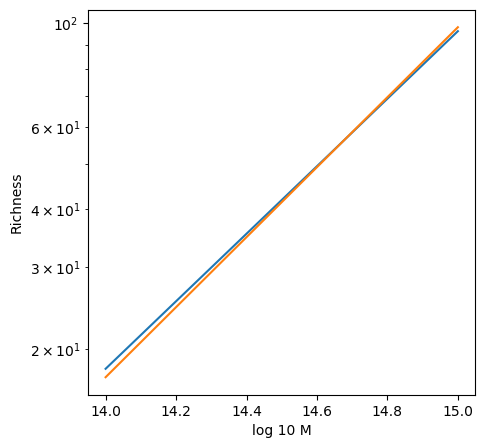

In [185]:
alpha_des = 0.75
B = np.log10( 10**12.37 / 10**11.13 )
log10Mmin = 11.13

alpha = 1/0.6
c = 3.4

plt.figure( figsize = ( 5 , 5 ) )
plt.plot( np.log10( np.exp( mu ) * 1e14 ) , constantin_power_law( mu , 0.4 , alpha , c , 0 ) , label = 'DES halo model')
plt.plot( np.log10( np.exp( mu ) * 1e14 ) , halo_model( mu , 0.4 , alpha_des , B , log10Mmin ) , label ='Constantin power-law')
plt.yscale('log')
plt.xlabel('log 10 M')
plt.ylabel('Richness')

In [163]:
stacked_simulator_pl.use_hybrid = True

In [17]:
len( richness_cents ) , len( redshift_cents ) 

(5, 5)

In [18]:
full_params = stacked_simulator_pl._get_parameter_set( torch.Tensor([ 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5 ]) )
richness, log10mwl , z , mu = stacked_simulator_pl._run_simulation( full_params )

0.3070000112056732 0.048254 0.6700000166893005 0.8299999833106995
3.200000047683716 0.0 2.200000047683716


In [19]:
log10mwl

array([14.02281992, 14.18089223, 14.17019759, ..., 15.12096547,
       15.07532689, 15.40049018])

(array([8.0275e+04, 5.2920e+03, 6.3800e+02, 1.3500e+02, 4.3000e+01,
        1.6000e+01, 6.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  2.51010004,  78.80670113, 155.10330223, 231.39990332,
        307.69650442, 383.99310551, 460.28970661, 536.5863077 ,
        612.8829088 , 689.17950989, 765.47611099]),
 <BarContainer object of 10 artists>)

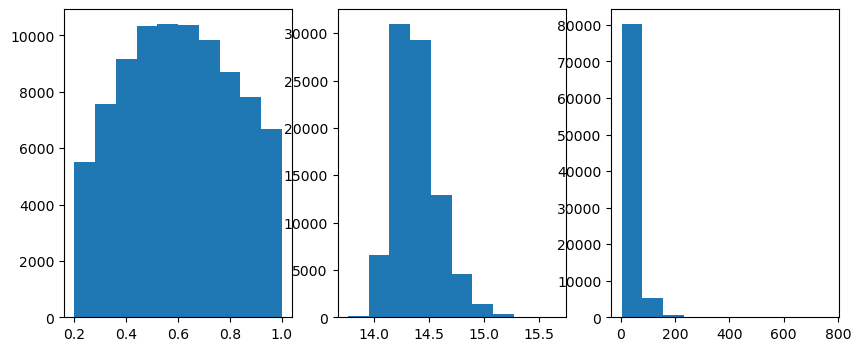

In [20]:
plt.figure( figsize = ( 10 , 4 ))
plt.subplot( 131 )
plt.hist( z )
plt.subplot( 132 )
plt.hist( log10mwl )
plt.subplot( 133 )
plt.hist( richness )


In [21]:
sim_obs = stacked_simulator_pl.run_simulation( torch.Tensor([ 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5 ]) )

0.3070000112056732 0.048254 0.6700000166893005 0.8299999833106995
3.200000047683716 0.0 2.200000047683716


In [22]:
sim_obs = stacked_simulator_pl.run_simulation( ([ 0.30711 , 0.8288 , 0.6777 , 2.2 , 3.2 , 0 , 0.5 ]) )

0.30711 0.048254 0.6777 0.8288
3.2 0.0 2.2


In [23]:
pinocchio_obs = np.vstack( [ pinocchio_mock['mean_count_richness_redshift'],  pinocchio_mock['mean_log10mass_richness_redshift'] ] ).flatten()

In [24]:
sim_n_clusters = sim_obs[:25].reshape( len( richness_cents ) , len( redshift_cents )  ).T
sim_mwl_mean = sim_obs[25:].reshape( len( richness_cents ), len( redshift_cents ) ).T

In [25]:
sim_n_clusters

array([[3343., 3027., 1831.,  738.,  269.],
       [5185., 4448., 2535., 1063.,  346.],
       [5592., 4940., 2657., 1024.,  274.],
       [5117., 4352., 2171.,  810.,  200.],
       [3983., 3245., 1630.,  542.,  126.]])

In [26]:
np.sum( pinocchio_mock['mean_count_richness_redshift'] )

60250.296

In [27]:
np.sum( sim_n_clusters ) / np.sum( pinocchio_mock['mean_count_richness_redshift'] )

0.9866839492373614

/tmp/ipykernel_3565/563058316.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


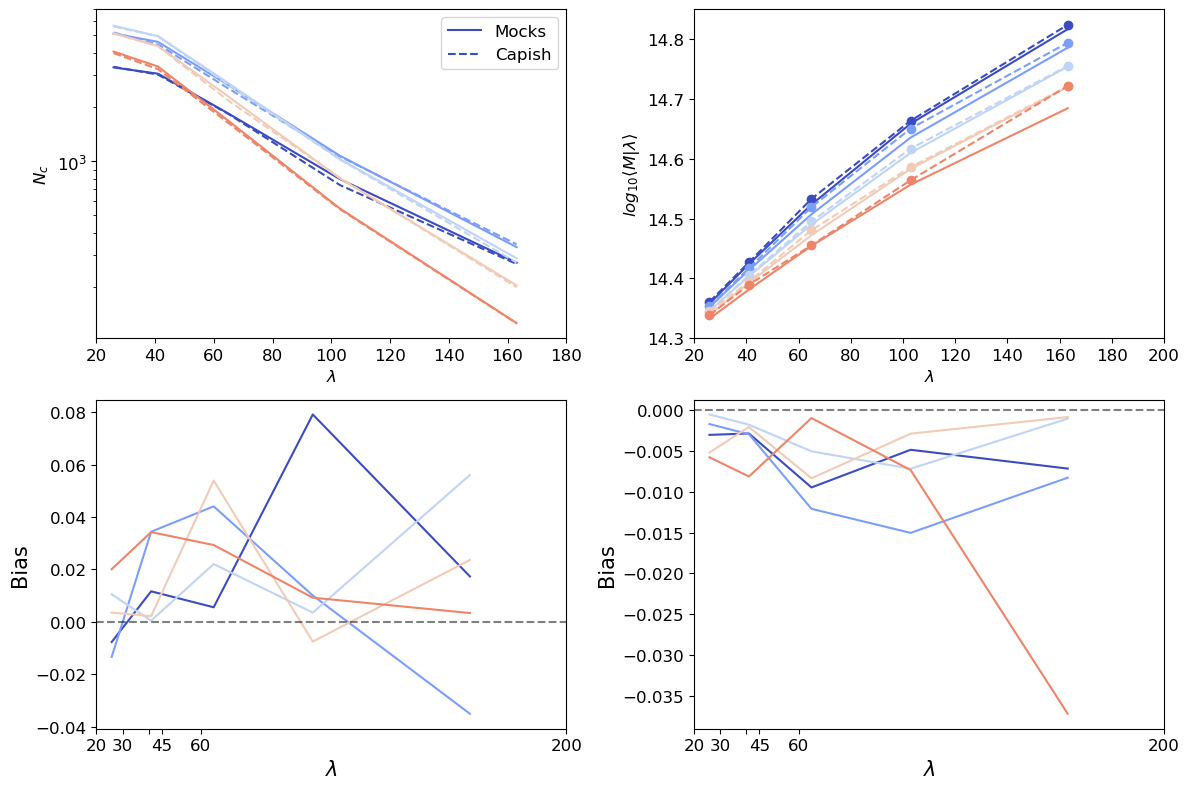

In [28]:
# Set the figure size
plt.figure(figsize=(12, 8))


plt.subplot(221)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(222)

alpha = 2.2
c = 3.2 
sigma = 0.5
beta = 0

mu = np.log( np.logspace( 14.2 , 14.8 , 10 )/1e14 )

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 14.3 , 14.85 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

plt.subplot(223)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_count_richness_redshift'].T[i]  - sim_n_clusters[i] )/sim_n_clusters[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
    
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )
#plt.ylim( -0.3 , 0.3 )

# Subplot 4: Residuals for MWL
plt.subplot(224)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] - sim_mwl_mean[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_3565/563058316.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


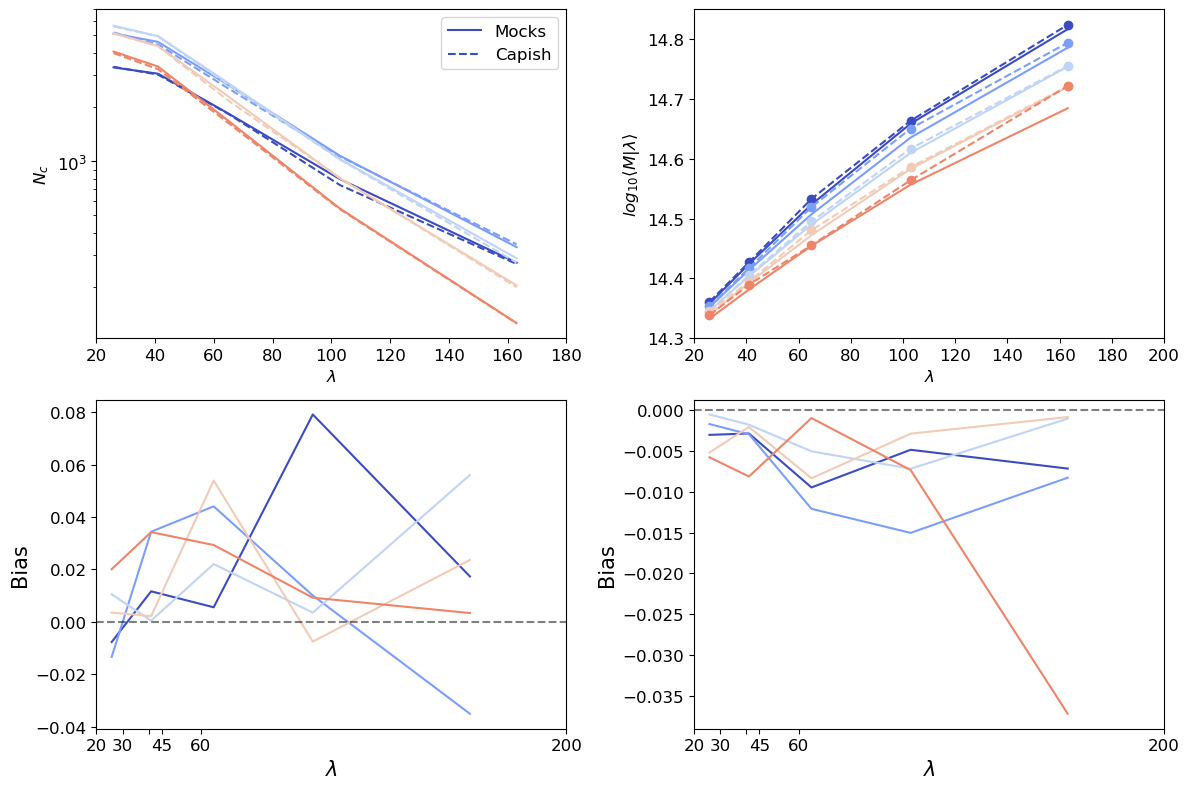

In [29]:
# Set the figure size
plt.figure(figsize=(12, 8))


plt.subplot(221)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(222)

alpha = 2.2
c = 3.2 
sigma = 0.5
beta = 0

mu = np.log( np.logspace( 14.2 , 14.8 , 10 )/1e14 )

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 14.3 , 14.85 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

plt.subplot(223)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_count_richness_redshift'].T[i]  - sim_n_clusters[i] )/sim_n_clusters[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
    
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )
#plt.ylim( -0.3 , 0.3 )

# Subplot 4: Residuals for MWL
plt.subplot(224)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] - sim_mwl_mean[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
stacked_simulator_pl.dlog10m

0.0009999999999994458

In [31]:
 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5  

(0.307, 0.83, 0.67, 2.2, 3.2, 0, 0.5)

In [32]:
# Define individual priors with correct tensor shape
prior_om = Uniform(torch.tensor([0.25]), torch.tensor([0.4]))
prior_s8 = Uniform(torch.tensor([0.7]), torch.tensor([1.]))
prior_h = Normal(torch.tensor([0.6777]), torch.tensor([0.001]))  # Normal prior on h
prior_alpha = Uniform(torch.tensor([2.]), torch.tensor([2.4]))
prior_c = Uniform(torch.tensor([2.0]), torch.tensor([5.0]))
prior_beta = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))
prior_sigma = Uniform(torch.tensor([0.05]), torch.tensor([1]))

# Combine the priors into a list for processing
priors = [ prior_om, prior_s8, prior_h, prior_alpha, prior_c , prior_beta , prior_sigma ]

In [33]:
n_meas = 20#len( 20 )
n_params = 7
n_sims = 10000
1 + ( n_meas - n_params ) / ( n_sims - n_meas )

1.0013026052104208

In [34]:
n_meas = 1e6
n_params = 7
n_sims = 1e7
1 + ( n_meas - n_params ) / ( n_sims - n_meas )

1.1111103333333334

In [35]:
# # decide if you want hybrid, SSC etc.
# stacked_simulator_pl.use_hybrid = True
# stacked_simulator_pl.poisson_only = False

# # infer posteriors
# pinocchio_posterior_calculator = infer( stacked_simulator_pl.run_simulation , 
#                              priors, 
#                              method = 'SNPE', 
#                              num_simulations = 1000 , 
#                              num_workers = 20 )

In [36]:
# with open('/sps/euclid/Users/cmurray/clusters_likelihood/pinocchio_posterior_calculator.pkl', 'rb') as file:
#     pinocchio_posterior_calculator = pickle.load(file)

In [37]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/pinocchio_posterior_calculator_SSC.pkl', 'rb') as file:
    pinocchio_posterior_calculator_SSC = pickle.load(file)

with open('/sps/euclid/Users/cmurray/clusters_likelihood/pinocchio_posterior_calculator_poisson_only.pkl', 'rb') as file:
    pinocchio_posterior_calculator_poisson_only = pickle.load(file)

with open('/sps/euclid/Users/cmurray/clusters_likelihood/pinocchio_posterior_calculator_SSC_hybrid.pkl', 'rb') as file:
    pinocchio_posterior_calculator_SSC_hybrid = pickle.load(file)

with open('/sps/euclid/Users/cmurray/clusters_likelihood/pinocchio_posterior_calculator_poisson_hybrid.pkl', 'rb') as file:
    pinocchio_posterior_calculator_poisson_hybrid = pickle.load(file)

In [102]:
# pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )

pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )

In [103]:
pinocchio_obs = np.vstack( [ pinocchio_mock['mean_count_richness_redshift'],  pinocchio_mock['mean_log10mass_richness_redshift'] ] ).flatten()

In [104]:
nsamples = 50000
# samples_sim = pinocchio_posterior_calculator.sample( (nsamples,), x = sim_obs )
samples_pin_SSC = pinocchio_posterior_calculator_SSC.sample( (nsamples,), x = pinocchio_obs )
samples_pin_po = pinocchio_posterior_calculator_poisson_only.sample( (nsamples,), x = pinocchio_obs )

samples_pin_SSC_h = pinocchio_posterior_calculator_SSC_hybrid.sample( (nsamples,), x = pinocchio_obs )
samples_pin_po_h = pinocchio_posterior_calculator_poisson_hybrid.sample( (nsamples,), x = pinocchio_obs )

Drawing 50000 posterior samples: 100%|██████████| 50000/50000 [00:01<00:00, 29325.66it/s]


In [105]:
# # save the chains
# np.save('samples_pin_SSC.npy', samples_pin_SSC )
# np.save('samples_pin_po.npy', samples_pin_po )
# np.save('samples_pin_SSC_h.npy', samples_pin_SSC_h )
# np.save('samples_pin_po_h.npy', samples_pin_po_h )

In [106]:
samples_pin_SSC.shape, samples_pin_po.shape, samples_pin_SSC_h.shape, samples_pin_po_h.shape

(torch.Size([50000, 6]),
 torch.Size([50000, 6]),
 torch.Size([50000, 6]),
 torch.Size([50000, 6]))

In [107]:
labels_math = ['\Omega_m' , '\sigma_8' , r'\alpha_{\lambda}' , 'c', r'\beta' , r'\sigma'  ]

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_pin_po.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mcmc = np.percentile( samples_pin_SSC.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [108]:
where = '/pbs/throng/lsst/users/cpayerne/capish/chains/'
data = np.load(where + f'pinochio_chain_NxMwl_fit_cosmo_num_params_rm_rel_4_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl', allow_pickle = True)
data = np.load(where + f'pinochio_chain_NxMwl_fit_cosmo_num_params_rm_rel_4_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl', allow_pickle = True)

In [109]:
data['flat_chains'].shape

(12000, 6)

In [110]:
# Desired order of labels
desired_order = ['\\Omega_m', '\\sigma_8', '\\mu_m', '\\ln \\lambda_0', '\\mu_z', '\\sigma_{\\ln \\lambda, 0}']

# Get the indices of the new order
reordered_indices = [data['label_parameters'].index(label) for label in desired_order]

# Reorder the flat_chains and label_parameters
reordered_chains = data['flat_chains'][:, reordered_indices]
reordered_labels = [data['label_parameters'][i] for i in reordered_indices]

# Updated data
data['flat_chains'] = reordered_chains[10000:]
data['label_parameters'] = reordered_labels

In [111]:
data['flat_chains'].shape

(2000, 6)

In [112]:
# for i in range(0,6):
#     plt.figure()
#     #plt.plot( reordered_chains.T[i] )
#     plt.plot( data['flat_chains'].T[i] )

In [113]:
labels = [r'$\Omega_m$' , r'$\sigma_8$' , r'$\alpha_{\lambda}$' , 'c', r'$\beta$' , r'$\sigma_{\lambda}$' ]
truths = [ 0.30711 , 0.8288 , 2.2 , 3.2 , 0 , 0.5  ]


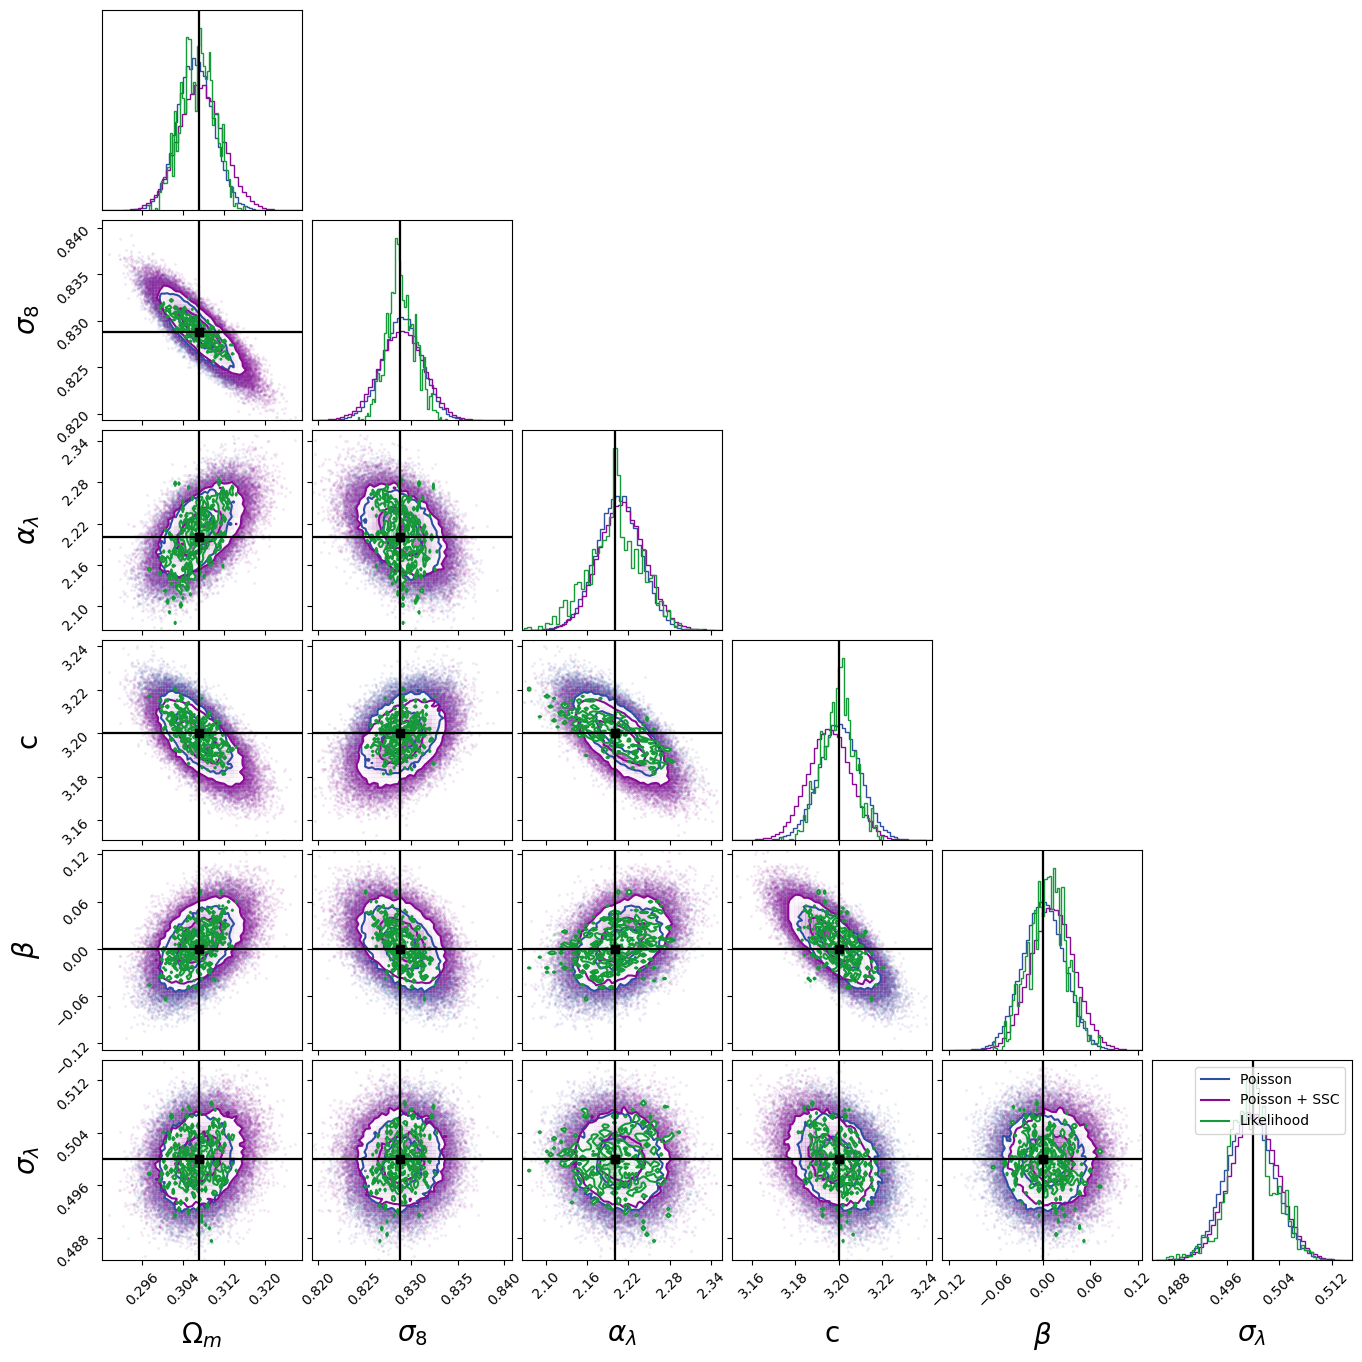

In [114]:
labels = [r'$\Omega_m$' , r'$\sigma_8$' , r'$\alpha_{\lambda}$' , 'c', r'$\beta$' , r'$\sigma_{\lambda}$' ]
truths = [ 0.30711 , 0.8288 , 2.2 , 3.2 , 0 , 0.5  ]


# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_pin_po.numpy(), 
                       levels=[0.393, 0.86],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#2d4ea1',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Add the alt_samples to the same corner plot
corner.corner(samples_pin_SSC.numpy(), fig=figure, 
                       levels=[0.393, 0.86],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#880a94',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

corner.corner( data['flat_chains'] , fig=figure, 
                       levels=[0.393, 0.86],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#159939',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'Poisson ')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Poisson + SSC')
plt.plot( [  0 ] , [ 0 ] , color = '#159939' , label = 'Likelihood')
plt.legend(loc="upper right")

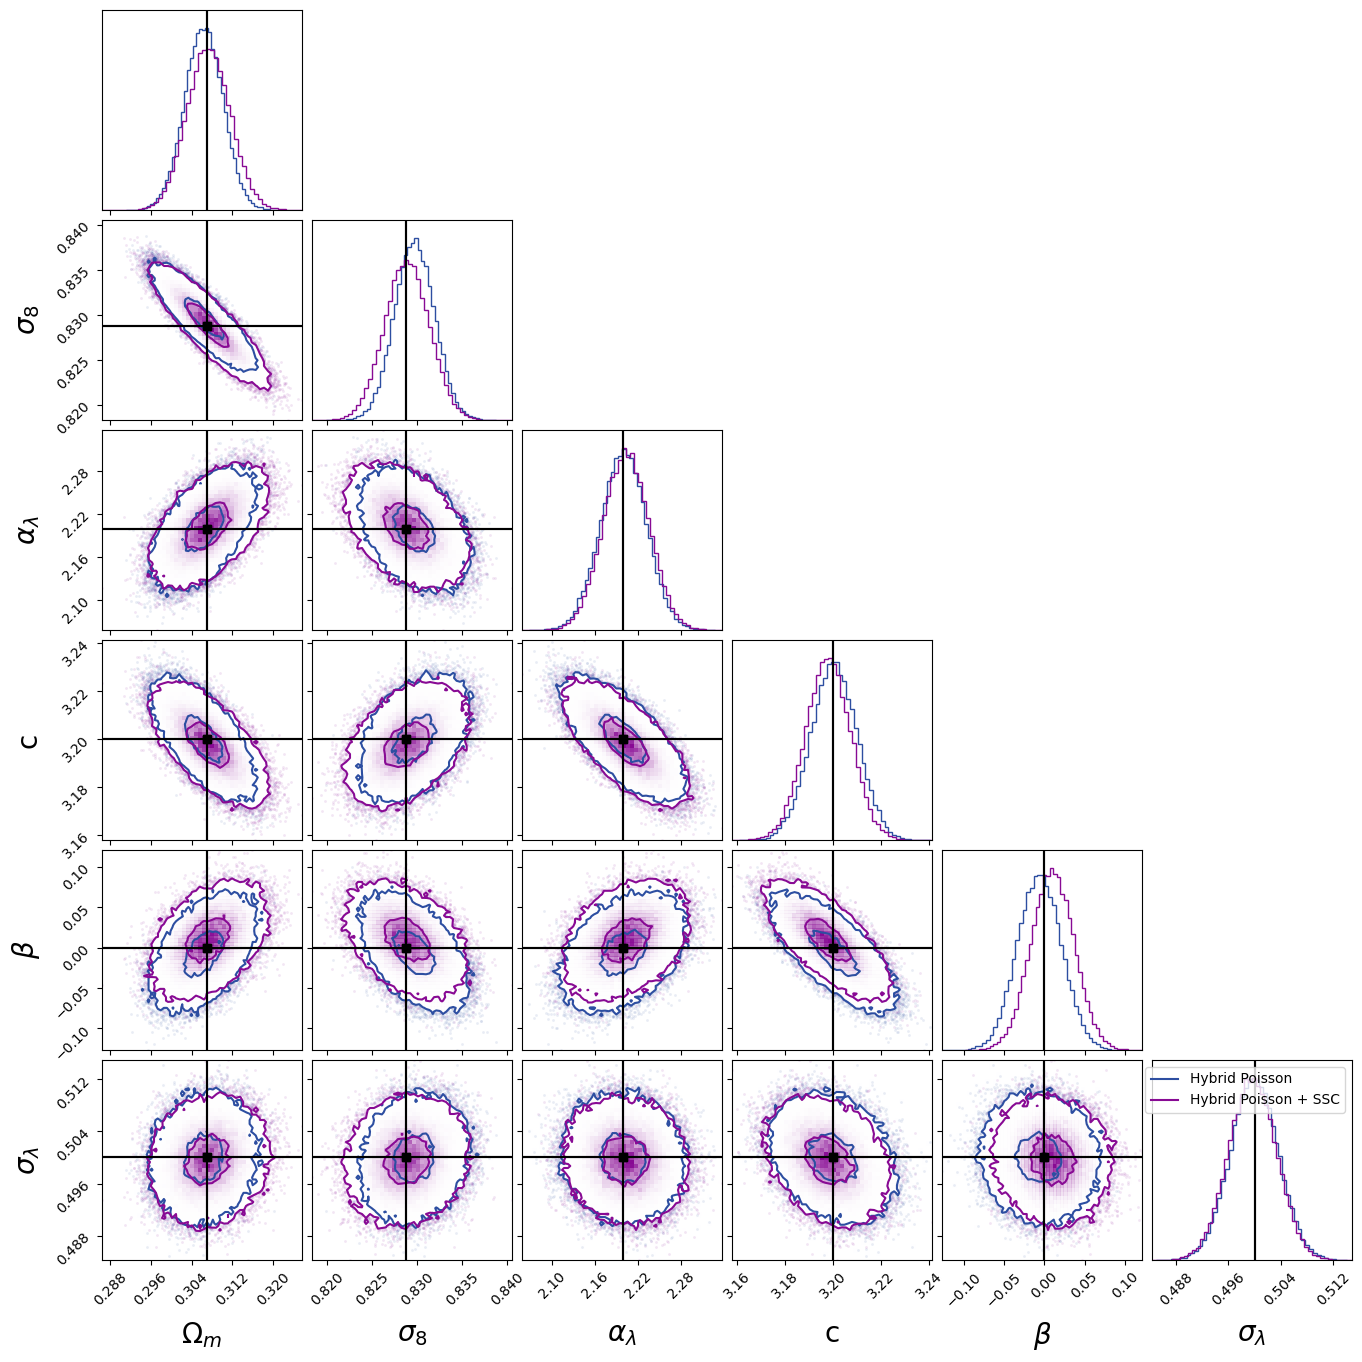

In [115]:
# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_pin_po_h.numpy(), 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#2d4ea1',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Add the alt_samples to the same corner plot
corner.corner(samples_pin_SSC_h.numpy(), fig=figure, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#880a94',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'Hybrid Poisson ')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Hybrid Poisson + SSC')
plt.legend(loc="upper right")

In [116]:
1 - np.exp(-(2/1)**2/2 )

0.8646647167633873

In [117]:
0.048254

0.048254

In [118]:
0.02208/0.6777**2

0.048075531886194504

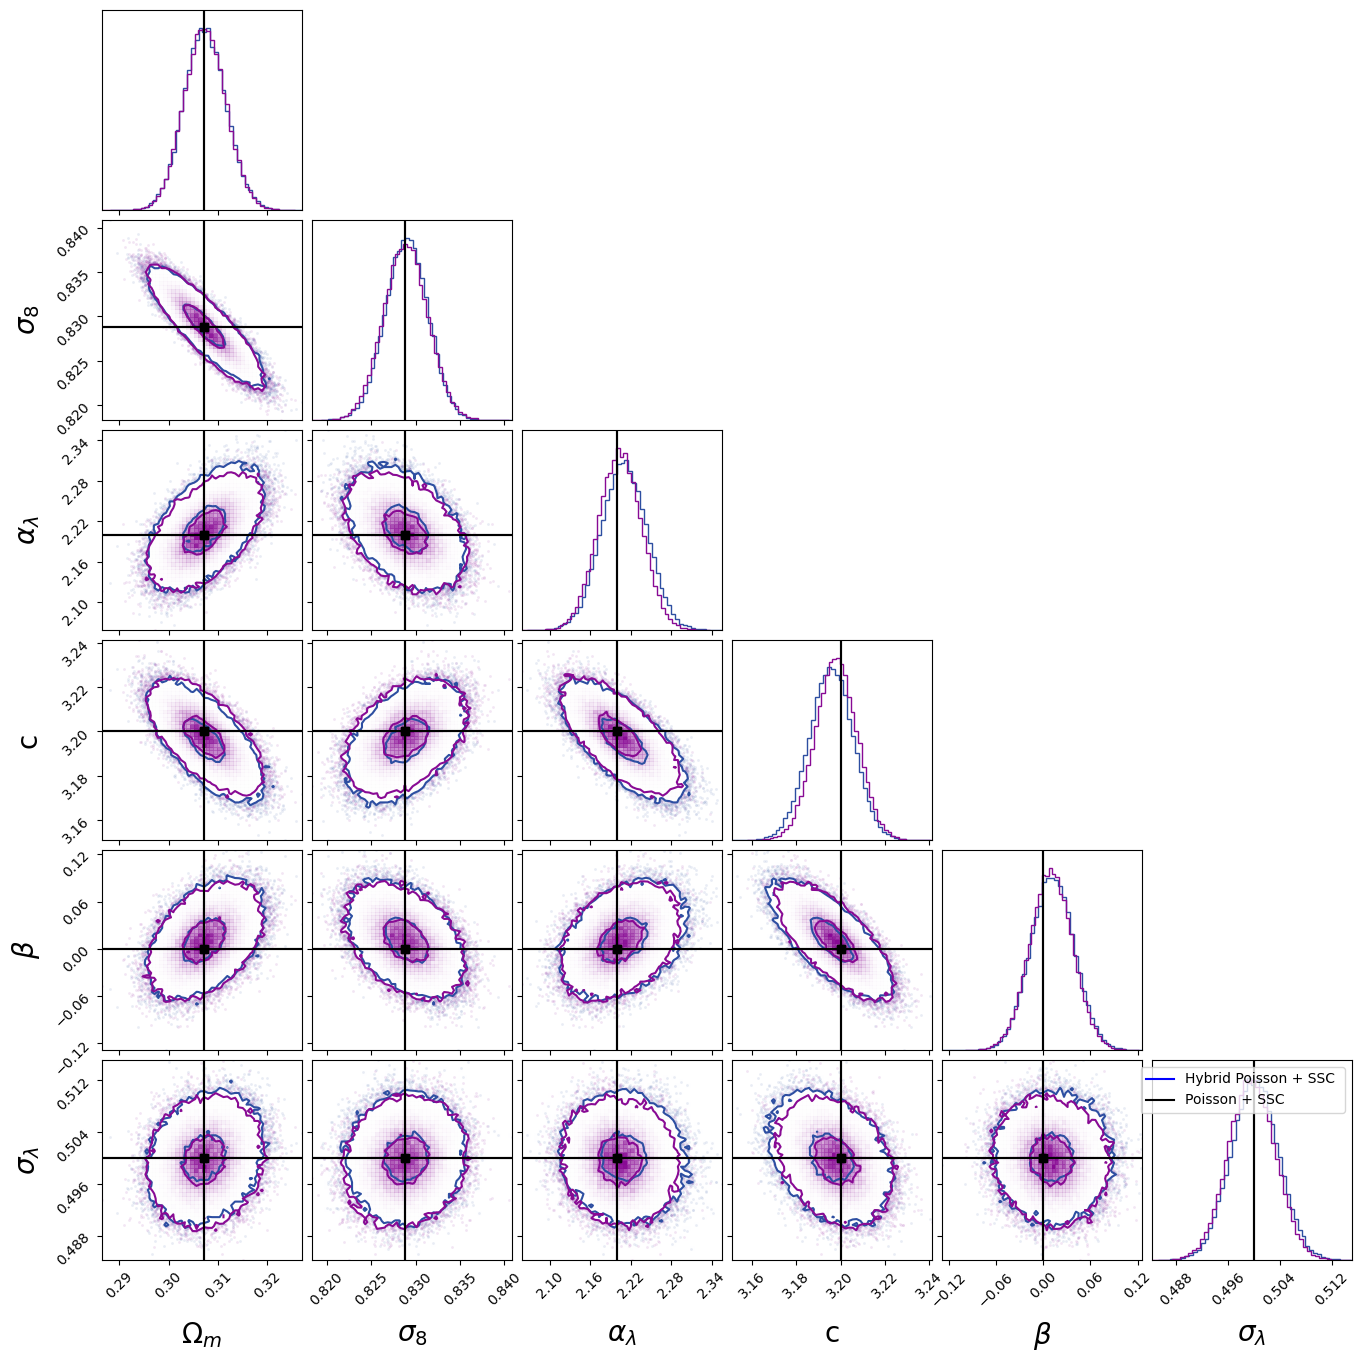

In [119]:
# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_pin_SSC.numpy(), 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#2d4ea1',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Add the alt_samples to the same corner plot
corner.corner(samples_pin_SSC_h.numpy(), fig=figure, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#880a94',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = 'b' , label = 'Hybrid Poisson + SSC ')
plt.plot( [  0 ] , [ 0 ] , color = 'k' , label = 'Poisson + SSC')
plt.legend(loc="upper right")
# plt.savefig('with_correct_h_value.pdf')

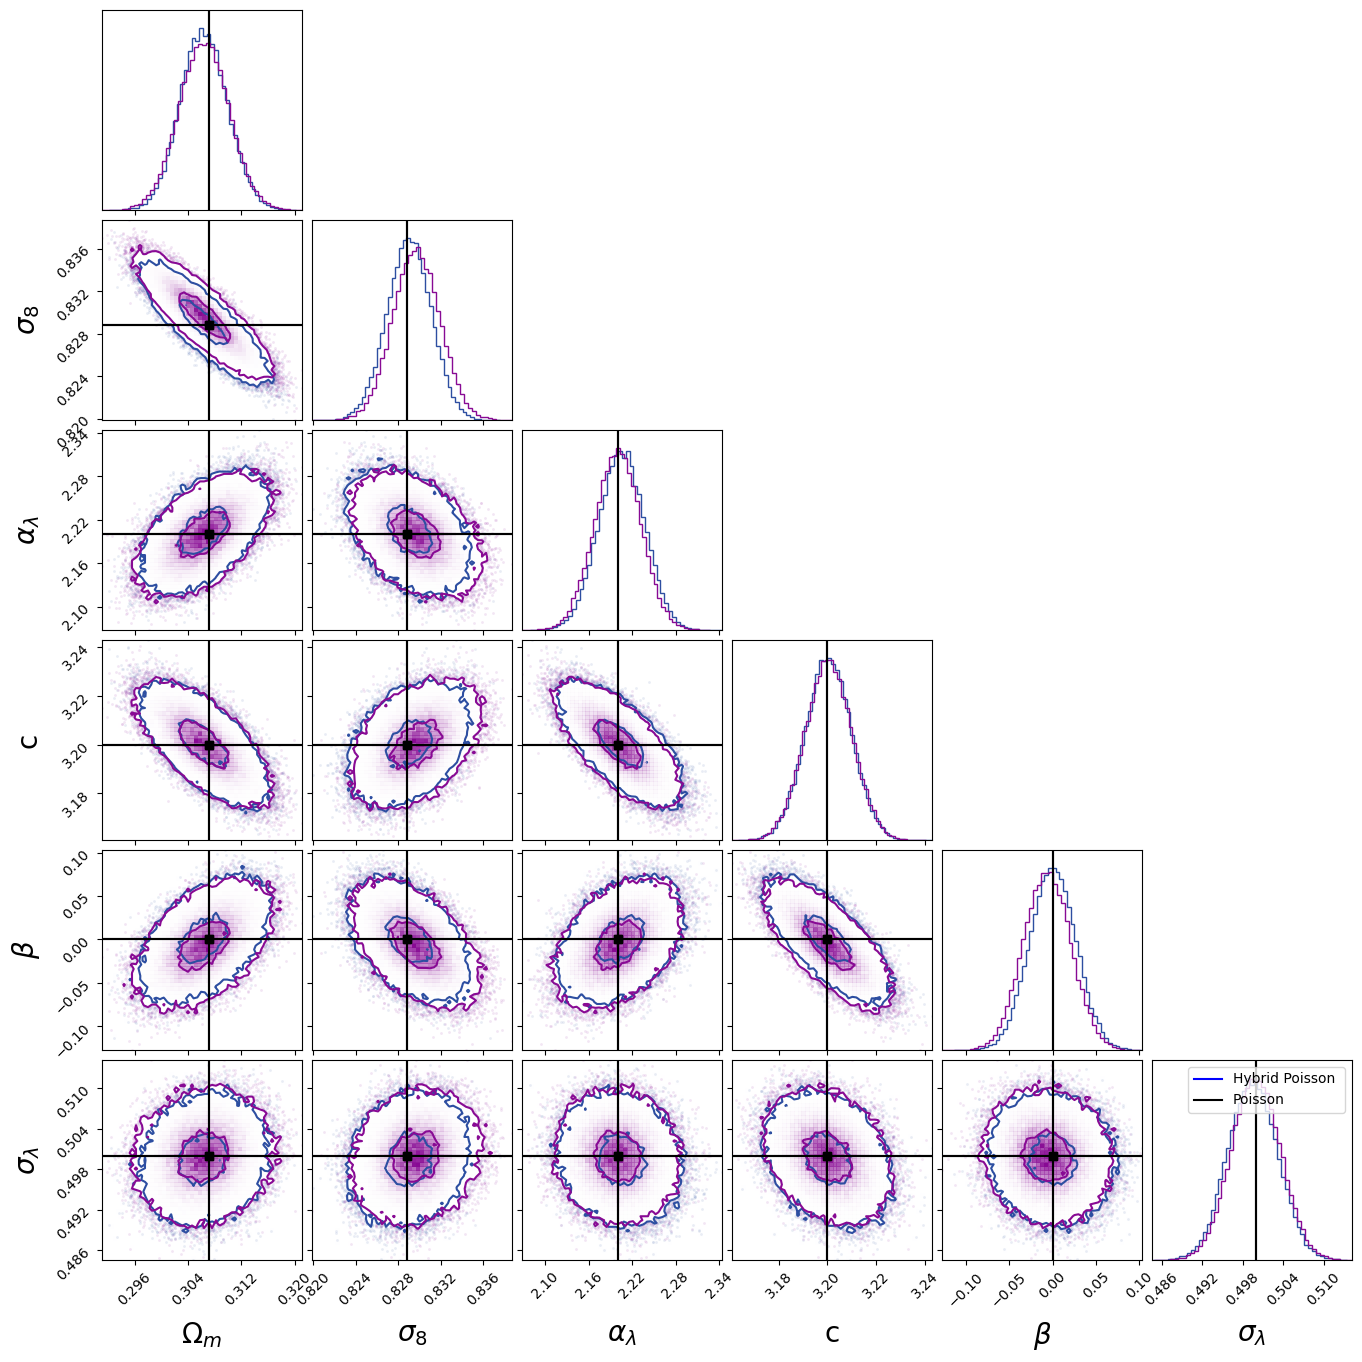

In [120]:
# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_pin_po.numpy(), 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#2d4ea1',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Add the alt_samples to the same corner plot
corner.corner(samples_pin_po_h.numpy(), fig=figure, 
                       levels=[0.393, 0.98],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#880a94',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = 'b' , label = 'Hybrid Poisson ')
plt.plot( [  0 ] , [ 0 ] , color = 'k' , label = 'Poisson')
plt.legend(loc="upper right")
# plt.savefig('poisson_only_with_correct_h_value.pdf')

In [121]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile(samples_pin_po.numpy()[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    
    # Format the string: param - truth: sigma
    param_diff = mcmc[1] - truths[i]
    sigma = param_diff / q[1]
    txt = r"\hat{{\mathrm{{{2}}}}} - \mathrm{{{2}}}: {0:.3f} \, \text{{. Number of }} \sigma \text{{ away}}: {1:.3f}"
    txt = txt.format(param_diff, sigma, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [122]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile(samples_pin_SSC.numpy()[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    
    # Format the string: param - truth: sigma
    param_diff = mcmc[1] - truths[i]
    sigma = param_diff / q[1]
    txt = r"\hat{{\mathrm{{{2}}}}} - \mathrm{{{2}}}: {0:.3f} \, \text{{. Number of }} \sigma \text{{ away}}: {1:.3f}"
    txt = txt.format(param_diff, sigma, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [123]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile(samples_pin_SSC_h.numpy()[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    
    # Format the string: param - truth: sigma
    param_diff = mcmc[1] - truths[i]
    sigma = param_diff / q[1]
    txt = r"\hat{{\mathrm{{{2}}}}} - \mathrm{{{2}}}: {0:.3f} \, \text{{. Number of }} \sigma \text{{ away}}: {1:.3f}"
    txt = txt.format(param_diff, sigma, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [124]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile(samples_pin_po.numpy()[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    
    # Format the string: param - truth: sigma
    param_diff = mcmc[1] - truths[i]
    sigma = param_diff / q[1]
    txt = r"\hat{{\mathrm{{{2}}}}} - \mathrm{{{2}}}: {0:.3f} \, \text{{. Number of }} \sigma \text{{ away}}: {1:.3f}"
    txt = txt.format(param_diff, sigma, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [125]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile( data['flat_chains'][:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    
    # Format the string: param - truth: sigma
    param_diff = mcmc[1] - truths[i]
    sigma = param_diff / q[1]
    txt = r"\hat{{\mathrm{{{2}}}}} - \mathrm{{{2}}}: {0:.3f} \, \text{{. Number of }} \sigma \text{{ away}}: {1:.3f}"
    txt = txt.format(param_diff, sigma, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [126]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile( data['flat_chains'][:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_l = q[1]
    
    mcmc = np.percentile( samples_pin_po_h[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_sbi = q[1]
    txt = r"\mathrm{{{2}}} \text{{ 1-sigma errors for Likelihood }}: {0:.4f} \, \text{{ SBI }}: {1:.4f}"
    txt = txt.format(sigma_l, sigma_sbi, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [127]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile( data['flat_chains'][:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_l = q[1]
    
    mcmc = np.percentile( samples_pin_po[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_sbi = q[1]
    txt = r"\mathrm{{{2}}} \text{{ 1-sigma errors for Likelihood }}: {0:.4f} \, \text{{ SBI }}: {1:.4f}"
    txt = txt.format(sigma_l, sigma_sbi, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [128]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile( data['flat_chains'][:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_l = q[1]
    
    mcmc = np.percentile( samples_pin_SSC[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_sbi = q[1]
    txt = r"\mathrm{{{2}}} \text{{ 1-sigma errors for Likelihood }}: {0:.4f} \, \text{{ SBI }}: {1:.4f}"
    txt = txt.format(sigma_l, sigma_sbi, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [129]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile( data['flat_chains'][:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_l = q[1]
    
    mcmc = np.percentile( samples_pin_SSC_h[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_sbi = q[1]
    txt = r"\mathrm{{{2}}} \text{{ 1-sigma errors for Likelihood }}: {0:.4f} \, \text{{ SBI }}: {1:.4f}"
    txt = txt.format(sigma_l, sigma_sbi, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [130]:
labels_math = [r'\Omega_m', r'\sigma_8', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile( data['flat_chains'][:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_l = mcmc[1]
    
    mcmc = np.percentile( samples_pin_SSC[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    sigma_sbi = mcmc[1]
    txt = r"\mathrm{{{2}}} \text{{ Bestfit Likelihood }}: {0:.4f} \, \text{{ SBI }}: {1:.4f}"
    txt = txt.format(sigma_l, sigma_sbi, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>